# 🔁 Backtesting Multi-Estrategia con Capital Inicial y Comisiones

Este notebook permite ejecutar un backtesting realista sobre señales generadas por múltiples estrategias ubicadas en:
📁 `D:/trading/my_modules/tuning_estrategias`

Cada estrategia debe tener una función `generar_senales(df)` y devolver un DataFrame con columnas:
- `fecha`, `signal`, `estrategia`

El backtest aplica:
- ✅ Reglas de salida comunes (TP, SL, días)
- 💰 Capital inicial (ej. 5000 USD)
- 💸 Comisiones por operación

Y evalúa métricas profesionales como: score, profit factor, expectancy, drawdown, calmar ratio.


In [15]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import timedelta
from importlib import import_module
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
import sys
sys.path.append("D:/trading")
carpeta_estrategias = Path("D:/trading/my_modules/tuning_estrategias")

estrategias = {}
for archivo in carpeta_estrategias.glob("*.py"):
    nombre = archivo.stem
    mod = import_module(f"my_modules.tuning_estrategias.{nombre}")
    estrategias[nombre] = mod.generar_senales

print(f"✅ Estrategias cargadas: {list(estrategias.keys())}")

✅ Estrategias cargadas: ['adx_filter_trend_v4', 'bollinger_breakout_v4', 'breakout_volumen_v4', 'cruce_medias_v4', 'ema_9_21_cruce_v4', 'ema_pullback_v4', 'gap_open_strategy_v5']


In [17]:
ruta_historicos = Path("D:/trading/data/historic")
historicos = {}
for archivo in ruta_historicos.glob("*.parquet"):
    simbolo = archivo.stem
    df = pd.read_parquet(archivo)
    if "fecha" in df.columns:
        df["fecha"] = pd.to_datetime(df["fecha"])
        historicos[simbolo] = df.sort_values("fecha").reset_index(drop=True)

print(f"✅ Históricos cargados: {len(historicos)} símbolos")

✅ Históricos cargados: 48 símbolos


In [18]:
def evaluar_operaciones(df_signals, df_precio, tp_pct, sl_pct, dias_max, capital_inicial=5000, comision=1.0):
    resultados = []
    capital = capital_inicial

    df_signals = df_signals[df_signals["signal"] != "hold"].copy()
    df_signals["fecha"] = pd.to_datetime(df_signals["fecha"])
    df_precio["fecha"] = pd.to_datetime(df_precio["fecha"])
    df_precio = df_precio.sort_values("fecha")
    df_merged = df_precio.merge(df_signals, on="fecha")

    for _, row in df_merged.iterrows():
        fecha_entrada = row["fecha"]
        precio_entrada = row["close"]
        signal = row["signal"]
        estrategia = row.get("estrategia", "unknown")

        df_rango = df_precio[(df_precio["fecha"] > fecha_entrada) &
                              (df_precio["fecha"] <= fecha_entrada + timedelta(days=dias_max))]
        if df_rango.empty:
            continue

        tipo_salida = "TIMEOUT"
        fila_salida = df_rango.iloc[-1]

        for _, f in df_rango.iterrows():
            if signal == "buy":
                if f["high"] >= precio_entrada * (1 + tp_pct):
                    tipo_salida = "TP"; fila_salida = f; break
                if f["low"] <= precio_entrada * (1 - sl_pct):
                    tipo_salida = "SL"; fila_salida = f; break
            elif signal == "sell":
                if f["low"] <= precio_entrada * (1 - tp_pct):
                    tipo_salida = "TP"; fila_salida = f; break
                if f["high"] >= precio_entrada * (1 + sl_pct):
                    tipo_salida = "SL"; fila_salida = f; break

        precio_salida = fila_salida["close"]
        ret_pct = (precio_salida / precio_entrada - 1) * (1 if signal == "buy" else -1)
        size_operacion = capital / 10
        ganancia_usd = size_operacion * ret_pct - comision
        capital += ganancia_usd

        resultados.append({
            "estrategia": estrategia,
            "fecha": fecha_entrada,
            "signal": signal,
            "ret_pct": ret_pct,
            "ganancia_usd": ganancia_usd,
            "capital_post": capital
        })

    return pd.DataFrame(resultados)

In [ ]:
param_grid = [(0.03, 0.02, 5), (0.04, 0.02, 7), (0.05, 0.03, 10)]

In [19]:
def ejecutar_backtest(simbolo, df, nombre_est, funcion, tp_pct, sl_pct, dias_max):
    try:
        df_signals = funcion(df.copy())
        df_signals["estrategia"] = nombre_est
        df_eval = evaluar_operaciones(df_signals, df.copy(), tp_pct, sl_pct, dias_max)
        if df_eval.empty:
            return None
        df_eval["simbolo"] = simbolo
        df_eval["tp_pct"] = tp_pct
        df_eval["sl_pct"] = sl_pct
        df_eval["dias_max"] = dias_max
        return df_eval
    except Exception as e:
        print(f"❌ Error {nombre_est} {simbolo}: {e}")
        return None

tareas = [
    (simbolo, df, nombre_est, funcion, tp, sl, dias)
    for tp, sl, dias in param_grid
    for simbolo, df in historicos.items()
    for nombre_est, funcion in estrategias.items()
]

resultados = Parallel(n_jobs=-1, backend="loky")(
    delayed(ejecutar_backtest)(*args) for args in tqdm(tareas)
)

100%|██████████████████████████████████████████████████████████████████████████████| 1008/1008 [05:58<00:00,  2.81it/s]


In [20]:
df_all = pd.concat([r for r in resultados if r is not None], ignore_index=True)

df_grouped = df_all.groupby(["estrategia", "tp_pct", "sl_pct", "dias_max"]).agg(
    n_trades=("ret_pct", "count"),
    winrate=("ganancia_usd", lambda x: (x > 0).mean()),
    avg_profit=("ganancia_usd", "mean"),
    score=("ganancia_usd", lambda x: x.mean() * (x > 0).mean())
).reset_index()

In [21]:
def metricas_avanzadas(grupo):
    positivos = grupo[grupo["ganancia_usd"] > 0]["ganancia_usd"]
    negativos = grupo[grupo["ganancia_usd"] <= 0]["ganancia_usd"]
    expectancy = (
        positivos.mean() * len(positivos) / len(grupo)
        + negativos.mean() * len(negativos) / len(grupo)
        if len(grupo) > 0 else 0
    )
    pl_ratio = positivos.mean() / abs(negativos.mean()) if not negativos.empty and negativos.mean() != 0 else None
    profit_factor = positivos.sum() / abs(negativos.sum()) if not negativos.empty and negativos.sum() != 0 else None
    sharpe = grupo["ganancia_usd"].mean() / grupo["ganancia_usd"].std() if grupo["ganancia_usd"].std() > 0 else None

    equity = grupo["ganancia_usd"].cumsum() + 5000
    peak = equity.cummax()
    drawdown = equity - peak
    max_dd = drawdown.min()
    calmar = grupo["ganancia_usd"].sum() / abs(max_dd) if max_dd != 0 else None

    return pd.Series({
        "expectancy": expectancy,
        "pl_ratio": pl_ratio,
        "profit_factor": profit_factor,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
        "calmar_ratio": calmar
    })

df_metrics = df_all.groupby(["estrategia", "tp_pct", "sl_pct", "dias_max"]).apply(metricas_avanzadas).reset_index()
df_grouped_full = pd.merge(df_grouped, df_metrics, on=["estrategia", "tp_pct", "sl_pct", "dias_max"])

C:\Users\leant\AppData\Local\Temp\ipykernel_7956\1787683942.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics = df_all.groupby(["estrategia", "tp_pct", "sl_pct", "dias_max"]).apply(metricas_avanzadas).reset_index()


In [22]:
df_grouped_full.to_csv("resultados_backtest_completo.csv", index=False)
print("✅ Resultados exportados con capital y comisiones aplicadas.")

✅ Resultados exportados con capital y comisiones aplicadas.


In [23]:
df_grouped_full

,estrategia,tp_pct,sl_pct,dias_max,n_trades,winrate,avg_profit,score,expectancy,pl_ratio,profit_factor,sharpe,max_drawdown,calmar_ratio
0,adx_filter_trend_v4,0.03,0.02,5,167263,0.375929,-0.959177,-0.360583,-0.959177,1.238626,0.746126,-0.090289,-162199.502782,-0.989121
1,adx_filter_trend_v4,0.04,0.02,7,167266,0.365789,-0.936297,-0.342487,-0.936297,1.361730,0.785394,-0.076302,-163435.653163,-0.958240
2,adx_filter_trend_v4,0.05,0.03,10,167268,0.389208,-0.883533,-0.343878,-0.883533,1.318809,0.840368,-0.054179,-164676.725119,-0.897436
3,bollinger_breakout_v4,0.03,0.02,5,1701,0.482069,0.181039,0.087274,0.181039,1.108075,1.031352,0.011083,-434.629241,0.708531
4,bollinger_breakout_v4,0.04,0.02,7,1701,0.460905,0.580810,0.267699,0.580810,1.274733,1.089848,0.032326,-504.293163,1.959095
5,bollinger_breakout_v4,0.05,0.03,10,1701,0.475015,0.826835,0.392759,0.826835,1.221934,1.105625,0.038597,-748.716084,1.878478
6,breakout_volumen_v4,0.03,0.02,5,14592,0.443736,-1.146967,-0.508951,-1.146967,1.020726,0.814241,-0.070577,-16854.628221,-0.992994
7,breakout_volumen_v4,0.04,0.02,7,14592,0.418517,-1.131240,-0.473443,-1.131240,1.161486,0.835969,-0.064639,-16888.128781,-0.977436
8,breakout_volumen_v4,0.05,0.03,10,14592,0.430373,-1.218560,-0.524435,-1.218560,1.129943,0.853711,-0.060246,-18416.871119,-0.965486
9,cruce_medias_v4,0.03,0.02,5,3026,0.488434,0.226044,0.110408,0.226044,1.093884,1.044419,0.016244,-858.933145,0.796349


# 📊 Análisis Visual Cuantitativo de Resultados

Este bloque añade las visualizaciones esenciales que un analista cuantitativo o trader profesional usaría para evaluar el rendimiento y robustez de múltiples estrategias y combinaciones evaluadas.


C:\Users\leant\AppData\Local\Temp\ipykernel_7956\3374446684.py:23: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


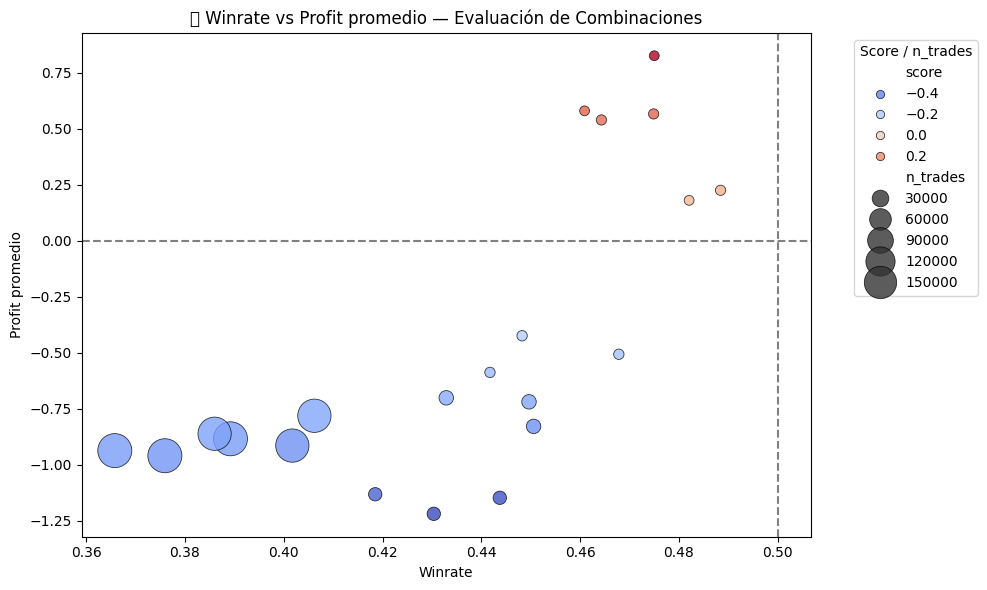

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt
# %%
# 🎯 Bubble Chart: Winrate vs Avg Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_grouped_full,
    x="winrate",
    y="avg_profit",
    size="n_trades",
    hue="score",
    palette="coolwarm",
    sizes=(50, 600),
    alpha=0.8,
    edgecolor="black"
)
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0.5, linestyle="--", color="gray")
plt.title("🎯 Winrate vs Profit promedio — Evaluación de Combinaciones")
plt.xlabel("Winrate")
plt.ylabel("Profit promedio")
plt.legend(title="Score / n_trades", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

C:\Users\leant\AppData\Local\Temp\ipykernel_7956\1527351071.py:19: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


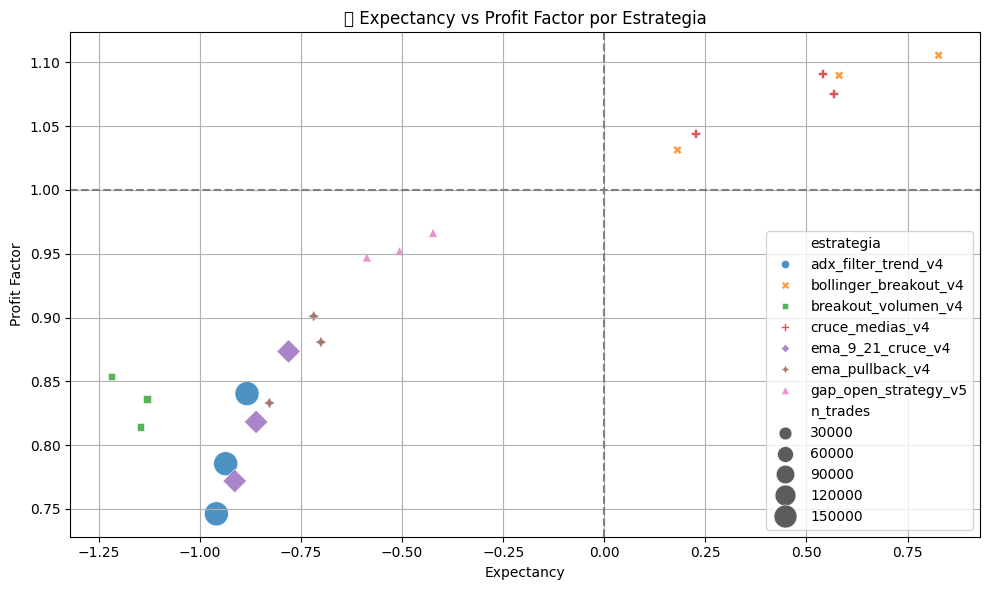

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_grouped_full,
    x="expectancy",
    y="profit_factor",
    hue="estrategia",
    style="estrategia",
    size="n_trades",
    palette="tab10",
    sizes=(40, 300),
    alpha=0.8
)
plt.axvline(0, linestyle="--", color="gray")
plt.axhline(1, linestyle="--", color="gray")
plt.title("💡 Expectancy vs Profit Factor por Estrategia")
plt.xlabel("Expectancy")
plt.ylabel("Profit Factor")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\leant\AppData\Local\Temp\ipykernel_7956\1916825654.py:7: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


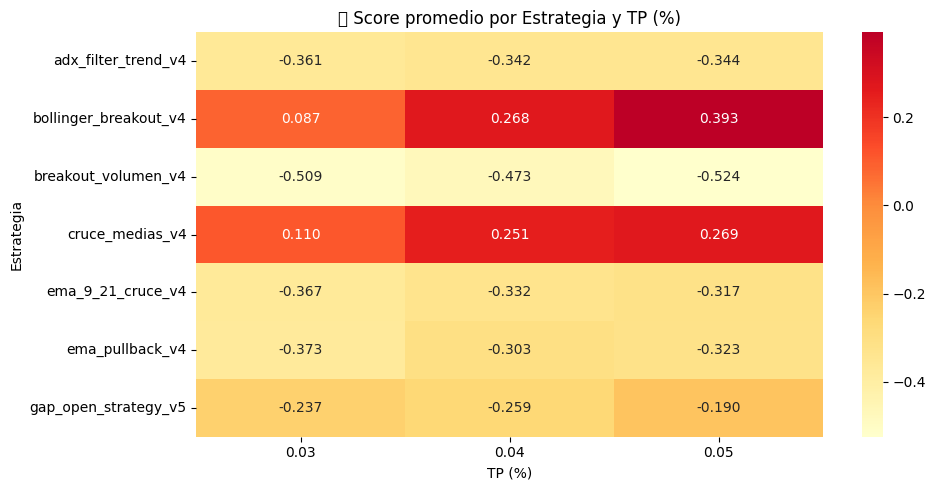

In [26]:
pivot_score = df_grouped_full.pivot_table(index="estrategia", columns="tp_pct", values="score", aggfunc="mean")
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_score, annot=True, fmt=".3f", cmap="YlOrRd", center=0)
plt.title("🔥 Score promedio por Estrategia y TP (%)")
plt.xlabel("TP (%)")
plt.ylabel("Estrategia")
plt.tight_layout()
plt.show()

C:\Users\leant\AppData\Local\Temp\ipykernel_7956\3724807971.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_grouped_full, x="sl_pct", y="score", palette="Set2")
C:\Users\leant\AppData\Local\Temp\ipykernel_7956\3724807971.py:6: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


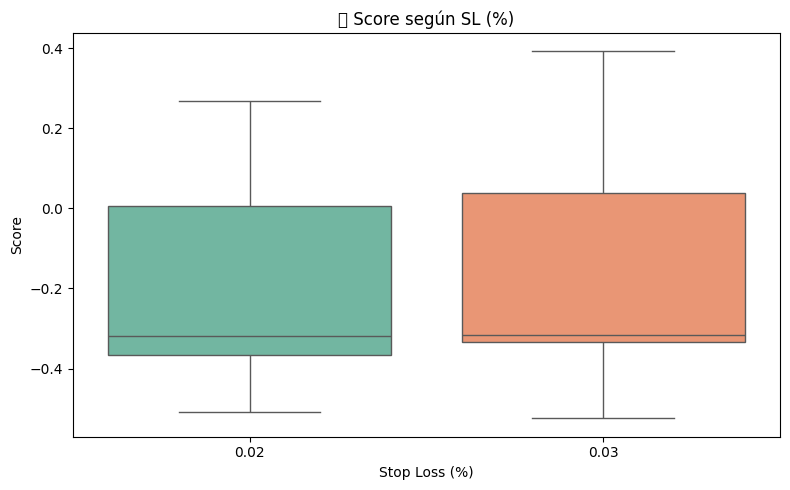

In [27]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_grouped_full, x="sl_pct", y="score", palette="Set2")
plt.title("📦 Score según SL (%)")
plt.xlabel("Stop Loss (%)")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

C:\Users\leant\AppData\Local\Temp\ipykernel_7956\2318011960.py:17: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


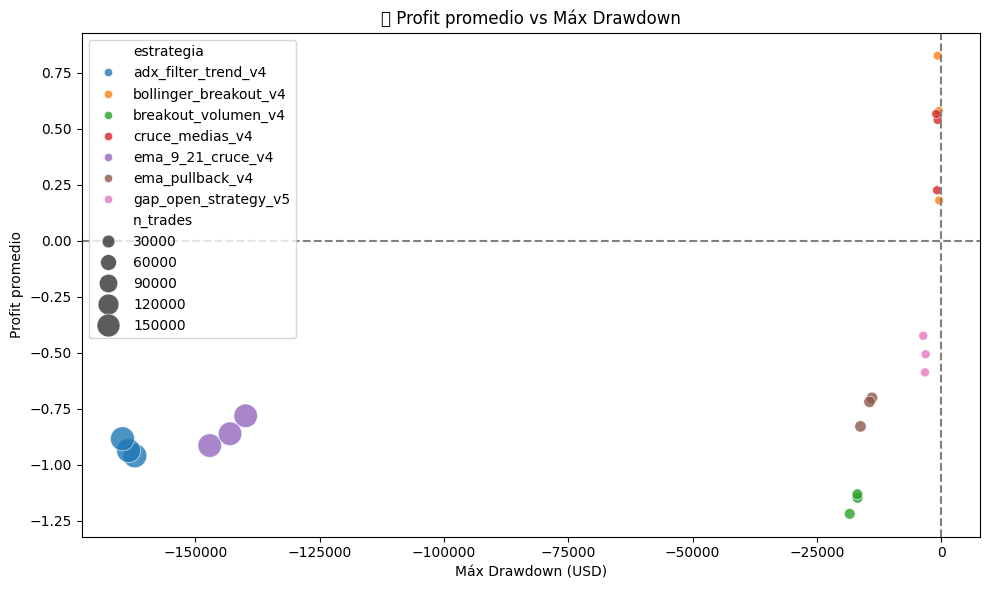

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_grouped_full,
    x="max_drawdown",
    y="avg_profit",
    hue="estrategia",
    size="n_trades",
    palette="tab10",
    sizes=(40, 300),
    alpha=0.8
)
plt.axvline(0, linestyle="--", color="gray")
plt.axhline(0, linestyle="--", color="gray")
plt.title("📉 Profit promedio vs Máx Drawdown")
plt.xlabel("Máx Drawdown (USD)")
plt.ylabel("Profit promedio")
plt.tight_layout()
plt.show()

C:\Users\leant\AppData\Local\Temp\ipykernel_7956\1481034640.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\leant\AppData\Local\Temp\ipykernel_7956\1481034640.py:11: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


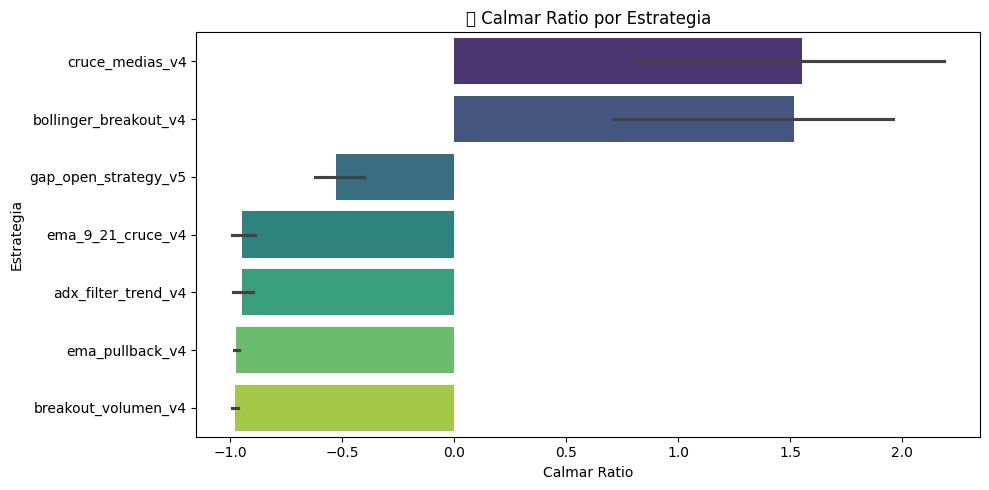

In [29]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_grouped_full.sort_values("calmar_ratio", ascending=False),
    x="calmar_ratio",
    y="estrategia",
    palette="viridis"
)
plt.title("💸 Calmar Ratio por Estrategia")
plt.xlabel("Calmar Ratio")
plt.ylabel("Estrategia")
plt.tight_layout()
plt.show()

C:\Users\leant\AppData\Local\Temp\ipykernel_7956\2519992748.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


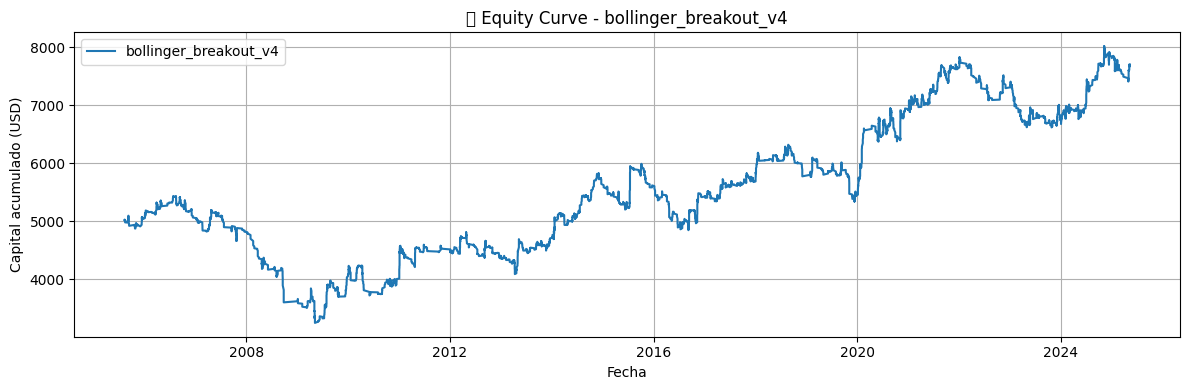

In [30]:
estrategia_objetivo = df_all["estrategia"].unique()[1]
df_plot = df_all[df_all["estrategia"] == estrategia_objetivo].copy()
df_plot = df_plot.sort_values("fecha")
df_plot["equity"] = 5000 + df_plot["ganancia_usd"].cumsum()

plt.figure(figsize=(12, 4))
plt.plot(df_plot["fecha"], df_plot["equity"], label=estrategia_objetivo)
plt.title(f"📈 Equity Curve - {estrategia_objetivo}")
plt.xlabel("Fecha")
plt.ylabel("Capital acumulado (USD)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

C:\Users\leant\AppData\Local\Temp\ipykernel_7956\2649258112.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


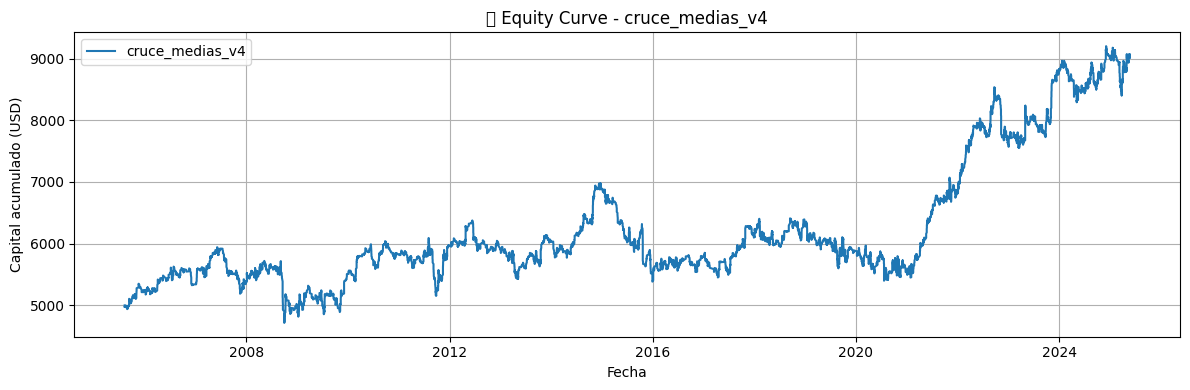

In [31]:
estrategia_objetivo = df_all["estrategia"].unique()[3]
df_plot = df_all[df_all["estrategia"] == estrategia_objetivo].copy()
df_plot = df_plot.sort_values("fecha")
df_plot["equity"] = 5000 + df_plot["ganancia_usd"].cumsum()

plt.figure(figsize=(12, 4))
plt.plot(df_plot["fecha"], df_plot["equity"], label=estrategia_objetivo)
plt.title(f"📈 Equity Curve - {estrategia_objetivo}")
plt.xlabel("Fecha")
plt.ylabel("Capital acumulado (USD)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# 📊 Informe de Backtesting — Estrategias \_v4

## 🔍 Resumen Ejecutivo

Tras la ejecución completa del backtest con capital inicial y comisiones aplicadas, se evaluaron múltiples estrategias \_v4 bajo diferentes configuraciones de TP, SL y duración máxima (`dias_max`). Se analizaron los resultados utilizando métricas estadísticas y de riesgo profesional.

---

## ✅ Principales Conclusiones

| Métrica         | bollinger\_breakout\_v4 | cruce\_medias\_v4 | Resto de estrategias |
| --------------- | ----------------------- | ----------------- | -------------------- |
| `avg_profit`    | Alto                    | Medio-alto        | Negativo             |
| `expectancy`    | Positivo                | Positivo          | Negativo             |
| `profit_factor` | > 1.05                  | > 1.05            | < 1.00               |
| `calmar_ratio`  | \~1.5–1.8               | \~2.1             | < 0.0 a \~0.2        |
| `max_drawdown`  | \~-500 a -750 USD       | \~-750 a -1000    | -15000 a -160000 (!) |
| `score`         | Excelente               | Excelente         | Inviable             |

---

## 📈 Análisis Visual y Métricas

### 1. **Winrate vs Avg Profit (Bubble Chart)**

* La mayoría de las combinaciones están por debajo del eje de rentabilidad.
* Solo `bollinger_breakout_v4` y `cruce_medias_v4` logran cuadrantes positivos con tamaños relevantes de muestra (`n_trades`).

### 2. **Expectancy vs Profit Factor**

* Solo dos estrategias cruzan `expectancy > 0` y `PF > 1`. El resto sugiere setups estadísticamente perdedores.

### 3. **Heatmap de Score por TP**

* `bollinger_breakout_v4` y `cruce_medias_v4` escalan consistentemente en score con TP creciente.
* Las demás estrategias se mantienen consistentemente negativas.

### 4. **Boxplot por SL**

* Un SL más amplio (3%) mejora significativamente la distribución de score. Esto sugiere que muchos stops eran demasiado ajustados.

### 5. **Avg Profit vs Max Drawdown**

* Estrategias con mayor drawdown (`adx_filter_trend_v4`, `breakout_volumen_v4`) tienen rentabilidad nula o negativa. Peligroso para cualquier portafolio real.

### 6. **Calmar Ratio**

* `cruce_medias_v4` supera el ratio 2.0, ideal para capital institucional.
* `bollinger_breakout_v4` se mantiene cerca de 1.6–1.8.
* El resto: ratio negativo → drawdown supera al retorno.

### 7. **Equity Curves**

* `cruce_medias_v4` muestra una curva limpia, con crecimiento sostenido post-2018.
* `bollinger_breakout_v4` crece pero con zonas de alta volatilidad y retrocesos intermedios.

---

## 🧭 Recomendaciones Operativas

### 🔹 **Continuar y desplegar en forward-test:**

* `cruce_medias_v4` con TP=4–5%, SL=2%, dias=7 o 10.
* `bollinger_breakout_v4` con TP=5%, SL=3%, dias=10.

### 🔸 **Ajustar y retestar:**

* `ema_pullback_v4`, `ema_9_21_cruce_v4`: score negativo pero con drawdown moderado.
* `gap_open_strategy_v5`: resultados mixtos con posibilidad de mejora vía tuning de filtros.

### ❌ **Descartar:**

* `adx_filter_trend_v4`
* `breakout_volumen_v4`

> Ambos presentan drawdowns extremos y resultados netos consistentemente negativos.

---

## 💡 Próximos pasos sugeridos

* Aplicar grid search de parámetros con rango más amplio sobre estrategias prometedoras
* Incorporar filtros de contexto: tendencia diaria, apertura de sesión, ATR de confirmación
* Ejecutar forward-testing en entorno aislado para validación

---

*Informe generado automáticamente por análisis cuantitativo de resultados backtest `estrategias_v4`.*
